In [1]:
import os
import itertools
from benchmarkrewriter.benchmark_parser import BenchmarkParser, WorkerBenchmarkParser
import json
import pandas as pd
import math

In [2]:
benchmark_path = '/benchmarks/'
results_path = '/results/'

results_path = r'C:\Users\huda\Downloads\results\\'
ga_path = r'C:\Users\huda\Downloads\ga_worker_results\results.json'
benchmark_path = r'C:\Users\huda\Documents\GitHub\scheduling_model_jrc\code\upgrades\benchmarks' # TODO: update to worker benchmarks
benchmark_path = r'C:\Users\huda\Documents\GitHub\scheduling_model_jrc\code\upgrades\benchmarks_with_workers'

In [3]:
def get_flexibility_and_dv(benchmark):
    all = 0
    unique = []
    durations = benchmark.durations()
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            if durations[i][j] > 0:
                if durations[i][j] not in unique:
                    unique.append(durations[i][j])
                all += 1.0

    return (all / len(durations)) / benchmark.n_machines(), len(unique) / all

def get_flexibility_and_dv_worker(benchmark):
    all = 0
    unique = []
    machines_available = 0
    durations = benchmark.durations()
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            for k in range(len(durations[i][j])):
                if durations[i][j][k] > 0:
                    if durations[i][j][k] not in unique:
                        unique.append(durations[i][j][k])
                    all += 1
            if any([x > 0 for x in durations[i][j]]):
                machines_available+=1
    return (machines_available / len(durations)) / benchmark.n_machines(), len(unique) / all
                

In [4]:
def read_benchmarks(path):
    sources = os.listdir(path)
    result = dict()
    for source in sources:
        b_path = path + '\\' + source + '\\'
        benchmarks = os.listdir(b_path)
        for benchmark in benchmarks:
            parser = BenchmarkParser()
            #parser = WorkerBenchmarkParser()
            data = parser.parse_benchmark(b_path + '\\' + benchmark)
            f, dv = get_flexibility_and_dv(data)
            #f, dv = get_flexibility_and_dv_worker(data)
            result[benchmark[:-4]] = {'n_operations': data.n_operations(), 'flexibility': f, 'duration_variety': dv, 'n_machines': data.n_machines()}

    return result

def read_benchmarks_workers(path):
    result = dict()
    benchmarks = os.listdir(path)
    for benchmark in benchmarks:
        #parser = BenchmarkParser()
        parser = WorkerBenchmarkParser()
        data = parser.parse_benchmark(path + '\\' + benchmark)
        #f, dv = get_flexibility_and_dv(data)
        f, dv = get_flexibility_and_dv_worker(data)
        instance_name = remap(benchmark[2:-12])
        result[instance_name] = {'n_operations': data.n_operations(), 'flexibility': f, 'duration_variety': dv, 'n_machines': data.n_machines()}

    return result

def remap(name):
    if name.startswith('_'):
        name = name[1:]
    values = name.split('_')
    if values[0].startswith('Behnke'):
        return 'Behnke'+values[1]
    if values[0].startswith('Brandimarte'):
        return 'BrandimarteMk'+values[1]
    if values[0].startswith('Chambers'):
        return 'ChambersBarnes'+values[1]
    if values[0].startswith('HurinkS'):
        return 'HurinkSdata'+values[1]
    if values[0].startswith('HurinkE'):
        return 'HurinkEdata'+values[1]
    if values[0].startswith('HurinkR'):
        return 'HurinkRdata'+values[1]
    if values[0].startswith('HurinkV'):
        return 'HurinkVdata'+values[1]
    if values[0].startswith('DP'):
        return 'DPpaulli'+values[1]
    if values[0].startswith('Kacem'):
        return 'Kacem'+values[1]
    if values[0].startswith('Fattahi'):
        return 'Fattahi'+values[1]
    return name

def read_results(path):
    files = os.listdir(path)
    #files = [path_to_results + r'results_ortools.txt', path_to_results +r'results_cplex_cp.txt', path_to_results +r'results_gurobi.txt', path_to_results +r'results_hexaly_rewritten.txt', path_to_results +r'results_cplex_lp_rewritten.txt']
    all_data = dict()
    data_as_dict = dict()
    known_optima = dict()
    for file in files:
        statuses = []
        optimal = 0
        feasible = 0
        infeasible = 0
        file_content = pd.read_csv(path + file, names=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'], sep=';')#, converters={'best_result_history': pd.eval})
        df = pd.DataFrame(file_content)
        name = file.split('\\')[-1][8:-4]
        if name == 'hexaly_rewritten':
            name = 'hexaly'#all_data['results_hexaly'] = df
        elif name == 'cplex_lp_rewritten':
            name = 'cplex_lp'#all_data['results_cplex_lp'] = df
        all_data[name] = df
        for index, row in df.iterrows():
            if row['name'].startswith('Error'):
                infeasible += 1
                continue
            if name not in data_as_dict:
                data_as_dict[name] = dict()
            instance_name = remap(row['name'][2:-12])
            if name == 'hexaly' or not row['optimization_status'] < 0:
                data_as_dict[name][instance_name] = row['fitness_value']
                if row['optimization_status'] == 1.0:
                    found = False
                    for optima in known_optima:
                        if optima[0] == instance_name:
                            found = True
                            break
                    if not found:
                        known_optima[instance_name] = row['fitness_value']#.append((instance_name, row['fitness_value']))
                    optimal += 1
                else:
                    feasible += 1
            else:
                infeasible += 1
            if row['optimization_status'] not in statuses:
                statuses.append(row['optimization_status'])
        print(f'{name}: {statuses} - optimal: {optimal}, feasible: {feasible}, infeasible: {infeasible}')
    return data_as_dict, known_optima

def read_ga_results(path):
    results = dict()
    with open(path, 'r') as f:
        ga_data = json.loads(f.read())

        results['ga_best'] = dict()
        results['ga_average'] = dict()
        for key in ga_data.keys():
            results['ga_best'][remap(key)] = ga_data[key]['best']
            results['ga_average'][remap(key)] = ga_data[key]['average']
    return results


In [5]:
#benchmark_data = read_benchmarks(benchmark_path)
benchmark_data = read_benchmarks_workers(benchmark_path)

In [6]:
results_data, known_optima = read_results(results_path)
ga_data = read_ga_results(ga_path)
for key in ga_data:
    results_data[key] = ga_data[key]
    optimal = 0
    feasible = 0
    infeasible = 0 # will stay 0, obviously
    for instance in ga_data[key]:
        if instance in known_optima and ga_data[key][instance] == known_optima[instance]:
            optimal += 1
        else:
            feasible += 1
    print(f'{key}:[0.0, 1.0] - optimal: {optimal}, feasible: {feasible}, infeasible: {infeasible}')
print(len(known_optima))
print(known_optima)

cplex_cp: [0.0, 1.0] - optimal: 55, feasible: 345, infeasible: 2
cplex_lp: [1.0, 0.0, -1.0] - optimal: 12, feasible: 309, infeasible: 81
gurobi: [0.0, -1.0, 1.0] - optimal: 15, feasible: 305, infeasible: 70
hexaly: [-1, 1] - optimal: 29, feasible: 373, infeasible: 0
ortools: [0.0, 1.0] - optimal: 39, feasible: 358, infeasible: 5
ga_best:[0.0, 1.0] - optimal: 17, feasible: 385, infeasible: 0
ga_average:[0.0, 1.0] - optimal: 14, feasible: 388, infeasible: 0
69
{'BrandimarteMk1': 38.0, 'Hurink_sdata_1': 52.0, 'Hurink_sdata_4': 622.0, 'Hurink_sdata_8': 565.0, 'Hurink_edata_1': 51.0, 'Hurink_edata_53': 6832.0, 'Hurink_edata_5': 620.0, 'Hurink_edata_7': 538.0, 'Hurink_edata_8': 481.0, 'Hurink_rdata_19': 656.0, 'Hurink_rdata_1': 44.0, 'Hurink_rdata_45': 748, 'Hurink_rdata_55': 4170.0, 'Hurink_vdata_19': 651.0, 'Hurink_vdata_1': 44.0, 'Hurink_vdata_20': 585.0, 'Hurink_vdata_21': 602.0, 'Hurink_vdata_22': 562.0, 'Hurink_vdata_23': 686.0, 'Hurink_vdata_2': 597.0, 'Hurink_vdata_39': 854.0, 'Hurin

In [7]:
def calculate_value(fitness, best):
    return ((fitness - best) / best)

In [8]:
best = dict()
for instance in benchmark_data.keys():
    best[instance] = None
    for solver in results_data.keys():
        if instance in results_data[solver] and not math.isinf(results_data[solver][instance]) and (not best[instance] or results_data[solver][instance] < best[instance]):
            best[instance] = int(results_data[solver][instance]+0.5) # just making sure it's properly rounded
best_solvers = dict()
not_best_solvers = dict()
not_best_solvers_including_fail = dict()
optimal_solvers = dict()
for instance in best.keys():
    best_solvers[instance] = []
    optimal_solvers[instance] = []
    not_best_solvers[instance] = []
    not_best_solvers_including_fail[instance] = []
    for solver in results_data.keys():
        if instance in known_optima and instance in results_data[solver] and results_data[solver][instance] == known_optima[instance]:
            optimal_solvers[instance].append(solver)
        if instance in results_data[solver] and results_data[solver][instance] == best[instance]:
            best_solvers[instance].append(solver)
        else:
            if instance in results_data[solver]:
                not_best_solvers[instance].append((solver, calculate_value(results_data[solver][instance], best[instance])))
                not_best_solvers_including_fail[instance].append((solver, calculate_value(results_data[solver][instance], best[instance])))
            else:
                not_best_solvers_including_fail[instance].append((solver, float('inf')))


In [9]:
str_combs = []
for i in range(1, len(best_solvers)+1):
    els = [list(x) for x in itertools.combinations(results_data.keys(), i)]
    for el in els:
        str_combs.append('-'.join(el))

In [10]:
instances_with_one_best = []
instances_with_some_best = []
instances_with_all_best = []
instances_all_best_including_ga_average = []
combinations = dict()
for comb in str_combs:
    combinations[comb] = 0
for instance in best_solvers.keys():
    best_solvers[instance].sort() # for later
    as_str = '-'.join(best_solvers[instance])
    if as_str not in combinations:
        combinations[as_str] = 0
    combinations[as_str] += 1
    if len(best_solvers[instance]) == 1:
        instances_with_one_best.append(instance)
    elif len(best_solvers[instance]) == len(results_data): # or whatever
        instances_all_best_including_ga_average.append(instance)
    elif 'ga_best' in best_solvers[instance] and 'cplex_cp' in best_solvers[instance] and 'cplex_lp' in best_solvers[instance] and 'gurobi' in best_solvers[instance] and 'hexaly' in best_solvers[instance] and 'ortools' in best_solvers[instance]:
        #just testing
        instances_with_all_best.append(instance)
    elif len(best_solvers[instance]) == len(results_data)-1 and 'ga_average' not in best_solvers[instance]:
        instances_with_all_best.append(instance)
    else:
        instances_with_some_best.append(instance)

In [11]:
print(f'Instances that could be solved by every solver: {len(instances_with_all_best)}')
print(f'Instances that could be solved by every solver (including GA Average): {len(instances_all_best_including_ga_average)}')
print(f'Instances that could only be solved by one sovler: {len(instances_with_one_best)}')

Instances that could be solved by every solver: 0
Instances that could be solved by every solver (including GA Average): 4
Instances that could only be solved by one sovler: 335


In [12]:
print('Co-Occurrences for best solution')
print(combinations)
comb_as_tuple = [(key, combinations[key]) for key in combinations]
comb_as_tuple.sort(key=lambda x: x[1], reverse=True)
print(comb_as_tuple)

Co-Occurrences for best solution
{'cplex_cp': 283, 'cplex_lp': 0, 'gurobi': 0, 'hexaly': 29, 'ortools': 15, 'ga_best': 8, 'ga_average': 0, 'cplex_cp-cplex_lp': 0, 'cplex_cp-gurobi': 0, 'cplex_cp-hexaly': 5, 'cplex_cp-ortools': 17, 'cplex_cp-ga_best': 5, 'cplex_cp-ga_average': 0, 'cplex_lp-gurobi': 0, 'cplex_lp-hexaly': 0, 'cplex_lp-ortools': 0, 'cplex_lp-ga_best': 0, 'cplex_lp-ga_average': 0, 'gurobi-hexaly': 0, 'gurobi-ortools': 0, 'gurobi-ga_best': 0, 'gurobi-ga_average': 0, 'hexaly-ortools': 0, 'hexaly-ga_best': 0, 'hexaly-ga_average': 0, 'ortools-ga_best': 0, 'ortools-ga_average': 0, 'ga_best-ga_average': 0, 'cplex_cp-cplex_lp-gurobi': 0, 'cplex_cp-cplex_lp-hexaly': 0, 'cplex_cp-cplex_lp-ortools': 0, 'cplex_cp-cplex_lp-ga_best': 0, 'cplex_cp-cplex_lp-ga_average': 0, 'cplex_cp-gurobi-hexaly': 0, 'cplex_cp-gurobi-ortools': 0, 'cplex_cp-gurobi-ga_best': 0, 'cplex_cp-gurobi-ga_average': 0, 'cplex_cp-hexaly-ortools': 16, 'cplex_cp-hexaly-ga_best': 0, 'cplex_cp-hexaly-ga_average': 0, 'cp

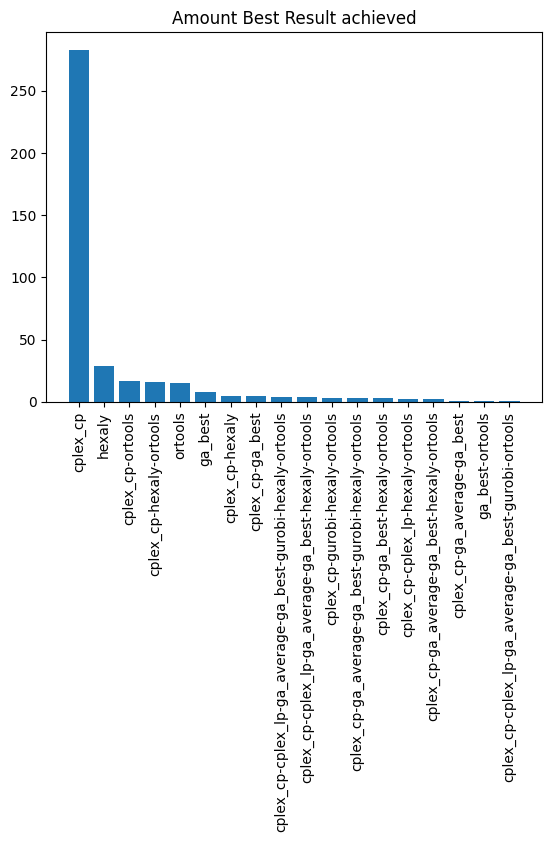

In [13]:
import matplotlib.pyplot as plt

plt.title('Amount Best Result achieved')
plt.bar([x[0] for x in comb_as_tuple if x[1] > 0 and x[0] != ''], [x[1] for x in comb_as_tuple if x[1] > 0 and x[0] != ''])
plt.xticks(rotation=90)
plt.show()

In [14]:
one_best_characteristics = dict()
some_best_characteristics = dict()
collected_best_characteristics = dict()
optimal_characteristics = dict()
for instance in optimal_solvers:
    for solver in optimal_solvers[instance]:
        if solver not in optimal_characteristics:
            optimal_characteristics[solver] = dict()
            optimal_characteristics[solver]['n_operations'] = []
            optimal_characteristics[solver]['flexibility'] = []
            optimal_characteristics[solver]['duration_variety'] = []
            optimal_characteristics[solver]['n_machines'] = []
        optimal_characteristics[solver]['n_operations'].append(benchmark_data[instance]['n_operations'])
        optimal_characteristics[solver]['flexibility'].append(benchmark_data[instance]['flexibility'])
        optimal_characteristics[solver]['duration_variety'].append(benchmark_data[instance]['duration_variety'])
        optimal_characteristics[solver]['n_machines'].append(benchmark_data[instance]['n_machines'])
for instance in instances_with_one_best:
    for solver in best_solvers[instance]:
        if solver not in one_best_characteristics:
            one_best_characteristics[solver] = dict()
            one_best_characteristics[solver]['n_operations'] = []
            one_best_characteristics[solver]['flexibility'] = []
            one_best_characteristics[solver]['duration_variety'] = []
            one_best_characteristics[solver]['n_machines'] = []
        if solver not in collected_best_characteristics:
            collected_best_characteristics[solver] = dict()
            collected_best_characteristics[solver]['n_operations'] = []
            collected_best_characteristics[solver]['flexibility'] = []
            collected_best_characteristics[solver]['duration_variety'] = []
            collected_best_characteristics[solver]['n_machines'] = []
        one_best_characteristics[solver]['n_operations'].append(benchmark_data[instance]['n_operations'])
        one_best_characteristics[solver]['flexibility'].append(benchmark_data[instance]['flexibility'])
        one_best_characteristics[solver]['duration_variety'].append(benchmark_data[instance]['duration_variety'])
        one_best_characteristics[solver]['n_machines'].append(benchmark_data[instance]['n_machines'])
        collected_best_characteristics[solver]['n_operations'].append(benchmark_data[instance]['n_operations'])
        collected_best_characteristics[solver]['flexibility'].append(benchmark_data[instance]['flexibility'])
        collected_best_characteristics[solver]['duration_variety'].append(benchmark_data[instance]['duration_variety'])
        collected_best_characteristics[solver]['n_machines'].append(benchmark_data[instance]['n_machines'])
for instance in instances_with_some_best:
    for solver in best_solvers[instance]:
        if solver not in some_best_characteristics:
            some_best_characteristics[solver] = dict()
            some_best_characteristics[solver]['n_operations'] = []
            some_best_characteristics[solver]['flexibility'] = []
            some_best_characteristics[solver]['duration_variety'] = []
            some_best_characteristics[solver]['n_machines'] = []
        if solver not in collected_best_characteristics:
            collected_best_characteristics[solver] = dict()
            collected_best_characteristics[solver]['n_operations'] = []
            collected_best_characteristics[solver]['flexibility'] = []
            collected_best_characteristics[solver]['duration_variety'] = []
            collected_best_characteristics[solver]['n_machines'] = []
        some_best_characteristics[solver]['n_operations'].append(benchmark_data[instance]['n_operations'])
        some_best_characteristics[solver]['flexibility'].append(benchmark_data[instance]['flexibility'])
        some_best_characteristics[solver]['duration_variety'].append(benchmark_data[instance]['duration_variety'])
        some_best_characteristics[solver]['n_machines'].append(benchmark_data[instance]['n_machines'])
        collected_best_characteristics[solver]['n_operations'].append(benchmark_data[instance]['n_operations'])
        collected_best_characteristics[solver]['flexibility'].append(benchmark_data[instance]['flexibility'])
        collected_best_characteristics[solver]['duration_variety'].append(benchmark_data[instance]['duration_variety'])
        collected_best_characteristics[solver]['n_machines'].append(benchmark_data[instance]['n_machines'])

In [15]:
import statistics
def get_stats(data, solver):
    result = dict()
    if solver in data:
        result['count'] = len(data[solver]['n_operations'])
        result['operations_mean'] = statistics.mean(data[solver]['n_operations'])
        result['operations_stdv'] = statistics.stdev(data[solver]['n_operations'])
        result['flexibility_mean'] = statistics.mean(data[solver]['flexibility'])
        result['flexibility_stdv'] = statistics.stdev(data[solver]['flexibility'])
        result['duration_variety_mean'] = statistics.mean(data[solver]['duration_variety'])
        result['duration_variety_stdv'] = statistics.stdev(data[solver]['duration_variety'])
        result['machines_mean'] = statistics.mean(data[solver]['n_machines'])
        result['machines_stdv'] = statistics.stdev(data[solver]['n_machines'])
    return result

stats_data = dict()
for solver in collected_best_characteristics.keys():
    if solver not in stats_data:
        stats_data[solver] = dict()
    if solver in one_best_characteristics:
        stats_data[solver]['one_best'] = get_stats(one_best_characteristics, solver)
    if solver in some_best_characteristics:
        stats_data[solver]['some_best'] = get_stats(some_best_characteristics, solver)
    if solver in collected_best_characteristics:
        stats_data[solver]['collected_best'] = get_stats(collected_best_characteristics, solver)
    if solver in optimal_characteristics:
        stats_data[solver]['optimal'] = get_stats(optimal_characteristics, solver)


In [16]:
def to_table_rows(data):
    table = ''
    for key in data:
        row = []
        if key == 'one_best':
            name = 'Single Best'
        elif key == 'some_best':
            name = 'Shared Best'
        elif key == 'optimal':
            name = 'Known Optimum'
        else:
            name = 'Combined'
        row.append(name)
        row.append('{:.1f}'.format(data[key]['count']))
        row.append('{:.4f}'.format(data[key]['machines_mean']))
        row.append('{:.4f}'.format(data[key]['machines_stdv']))
        row.append('{:.4f}'.format(data[key]['operations_mean']))
        row.append('{:.4f}'.format(data[key]['operations_stdv']))
        row.append('{:.4f}'.format(data[key]['flexibility_mean']))
        row.append('{:.4f}'.format(data[key]['flexibility_stdv']))
        row.append('{:.4f}'.format(data[key]['duration_variety_mean']))
        row.append('{:.4f}'.format(data[key]['duration_variety_stdv']))
        table += ' & '.join(row)[:-1] + '\\'
    return table

In [17]:
to_table_rows(stats_data['cplex_cp'])

'Single Best & 283.0 & 14.1413 & 12.5521 & 175.9647 & 112.4890 & 0.2751 & 0.1489 & 0.1026 & 0.177\\Shared Best & 62.0 & 9.0968 & 10.8548 & 64.3226 & 52.9753 & 0.3818 & 0.2549 & 0.3113 & 0.293\\Combined & 345.0 & 13.2348 & 12.4022 & 155.9014 & 112.7542 & 0.2943 & 0.1772 & 0.1401 & 0.218\\Known Optimum & 69.0 & 7.1739 & 3.3429 & 73.9855 & 62.0568 & 0.4145 & 0.2251 & 0.3059 & 0.303\\'

In [18]:
to_table_rows(stats_data['ga_best'])

'Single Best & 8.0 & 54.3750 & 15.9099 & 217.5000 & 192.4095 & 0.2979 & 0.0504 & 0.0007 & 0.001\\Shared Best & 20.0 & 13.3000 & 17.9827 & 51.2500 & 76.3923 & 0.5725 & 0.3147 & 0.3726 & 0.355\\Combined & 28.0 & 25.0357 & 25.5002 & 98.7500 & 139.8368 & 0.4940 & 0.2937 & 0.2664 & 0.343\\Known Optimum & 17.0 & 4.6471 & 2.4223 & 12.1176 & 7.1229 & 0.6321 & 0.2663 & 0.6181 & 0.260\\'

In [19]:
to_table_rows(stats_data['ortools'])

'Single Best & 15.0 & 7.4667 & 2.4456 & 78.0000 & 29.3331 & 0.1975 & 0.1134 & 0.3061 & 0.260\\Shared Best & 52.0 & 6.2692 & 3.0040 & 56.3462 & 39.8216 & 0.3920 & 0.2554 & 0.3619 & 0.293\\Combined & 67.0 & 6.5373 & 2.9146 & 61.1940 & 38.6081 & 0.3485 & 0.2445 & 0.3494 & 0.285\\Known Optimum & 48.0 & 5.6667 & 2.2345 & 47.3125 & 33.5788 & 0.4291 & 0.2571 & 0.3960 & 0.296\\'

In [20]:
to_table_rows(stats_data['hexaly'])

'Single Best & 29.0 & 10.1034 & 1.9151 & 116.7586 & 52.2478 & 0.1322 & 0.0876 & 0.1424 & 0.153\\Shared Best & 38.0 & 6.3421 & 3.2572 & 57.6842 & 52.8466 & 0.3886 & 0.2779 & 0.3483 & 0.279\\Combined & 67.0 & 7.9701 & 3.3211 & 83.2537 & 59.9453 & 0.2776 & 0.2509 & 0.2592 & 0.253\\Known Optimum & 37.0 & 5.4324 & 2.1543 & 50.2703 & 54.4098 & 0.4248 & 0.2749 & 0.3984 & 0.289\\'

In [21]:
to_table_rows(stats_data['cplex_lp'])

'Shared Best & 7.0 & 4.2857 & 2.2147 & 19.1429 & 17.2668 & 0.5388 & 0.3409 & 0.5809 & 0.299\\Combined & 7.0 & 4.2857 & 2.2147 & 19.1429 & 17.2668 & 0.5388 & 0.3409 & 0.5809 & 0.299\\Known Optimum & 11.0 & 4.1818 & 1.8340 & 15.7273 & 14.2133 & 0.5206 & 0.2778 & 0.6506 & 0.254\\'

In [22]:
to_table_rows(stats_data['gurobi'])

'Shared Best & 7.0 & 6.5714 & 2.1492 & 30.0000 & 21.7025 & 0.5914 & 0.2848 & 0.2635 & 0.304\\Combined & 7.0 & 6.5714 & 2.1492 & 30.0000 & 21.7025 & 0.5914 & 0.2848 & 0.2635 & 0.304\\Known Optimum & 11.0 & 5.6364 & 2.2033 & 22.6364 & 19.6889 & 0.5541 & 0.2412 & 0.4486 & 0.350\\'

In [23]:
solvers = list(collected_best_characteristics.keys())
solvers.remove('ga_average')

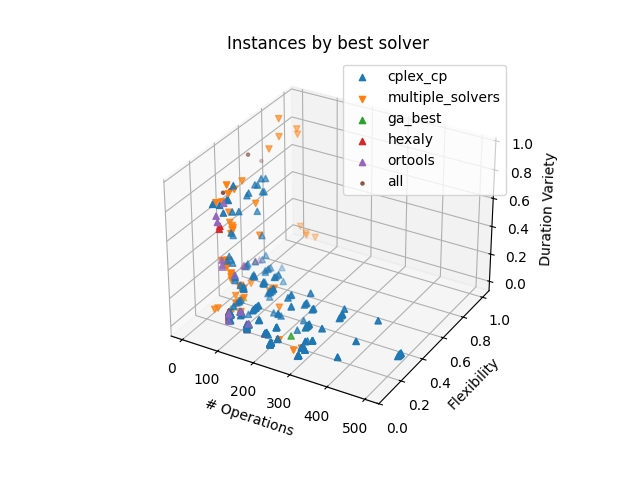

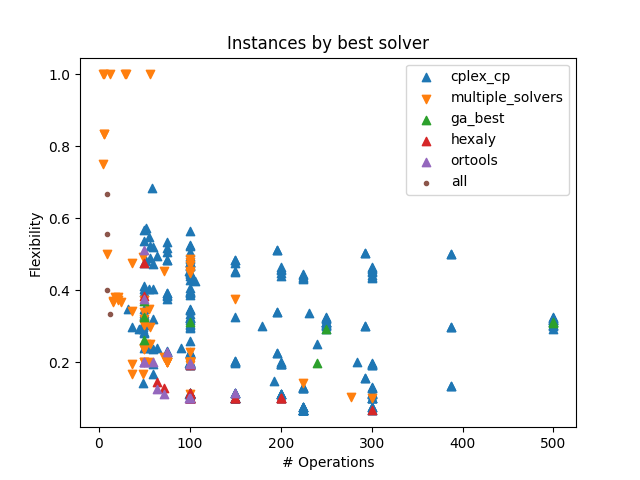

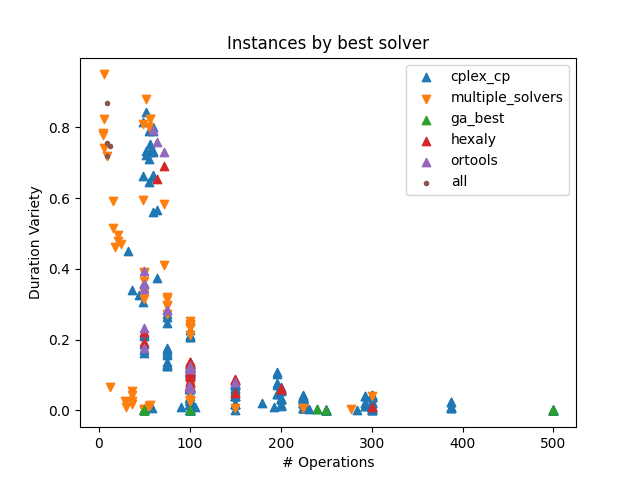

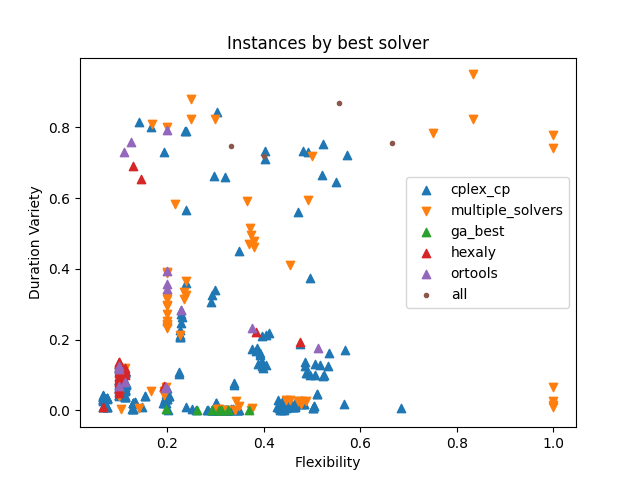

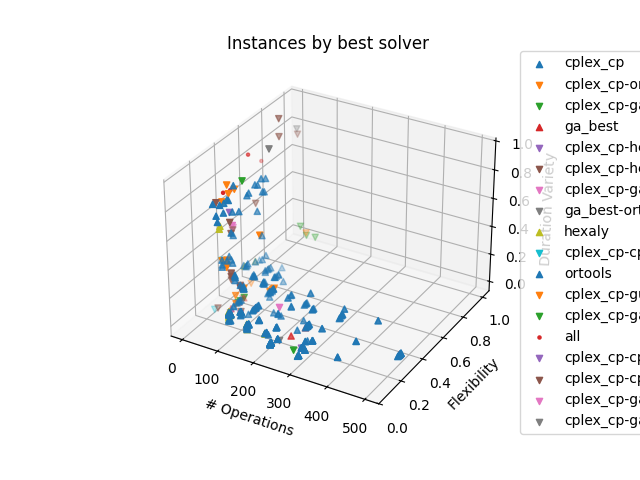

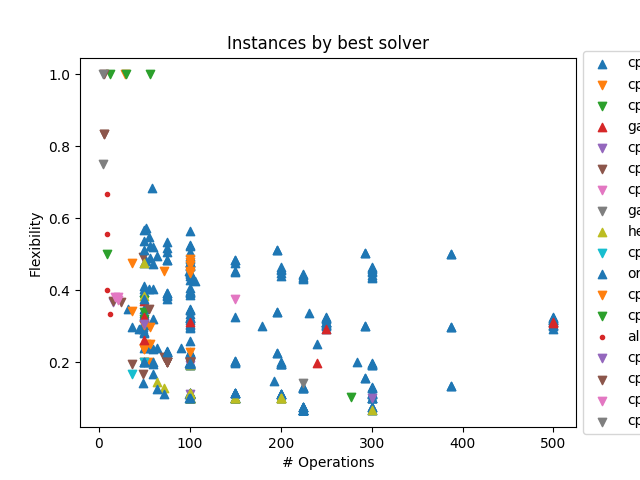

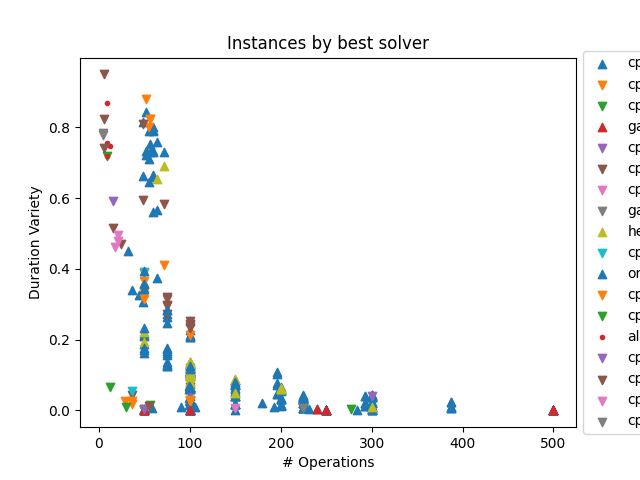

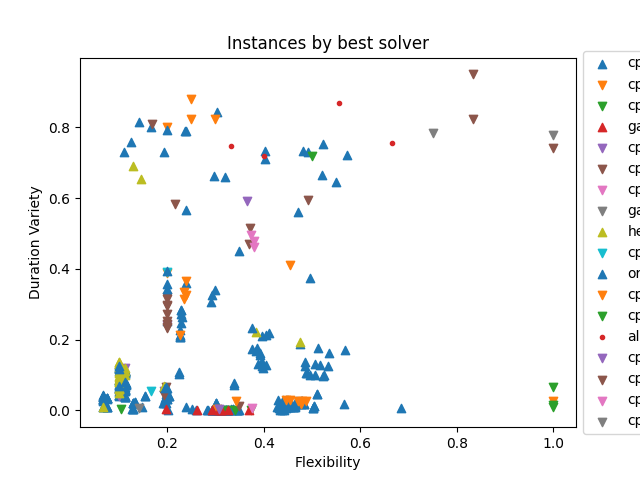

In [24]:
%matplotlib widget 
import matplotlib.pyplot as plt
def scatter_3d_grouped(f, o , dv, labels, markers, xlabel, ylabel, zlabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    one_solver = dict()
    for i in range(len(f)):
        if markers[i] == '^':
            if labels[i] not in one_solver:
                one_solver[labels[i]] = []
            one_solver[labels[i]].append([f[i], o[i], dv[i], '^', 'r'])
        elif markers[i] == 'v':
            if 'multiple_solvers' not in one_solver:
                one_solver['multiple_solvers'] = []
            one_solver['multiple_solvers'].append([f[i], o[i], dv[i], 'v', 'g'])
        else:
            if 'all' not in one_solver:
                one_solver['all'] = []
            one_solver['all'].append([f[i], o[i], dv[i], '.', 'b'])
    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], [x[2] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][3])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    ax.legend()
    plt.show()

def scatter_2d_grouped(x, y, labels, markers, xlabel, ylabel, title):
    fig = plt.figure()
    ax = fig.add_subplot()
    one_solver = dict()
    for i in range(len(x)):
        if markers[i] == '^':
            if labels[i] not in one_solver:
                one_solver[labels[i]] = []
            one_solver[labels[i]].append([x[i], y[i], '^', 'r'])
        elif markers[i] == 'v':
            if 'multiple_solvers' not in one_solver:
                one_solver['multiple_solvers'] = []
            one_solver['multiple_solvers'].append([x[i], y[i], 'v', 'g'])
        else:
            if 'all' not in one_solver:
                one_solver['all'] = []
            one_solver['all'].append([x[i], y[i], '.', 'b'])
    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][2])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    plt.show()

def scatter_3d(f, o , dv, labels, markers, xlabel, ylabel, zlabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    one_solver = dict()
    for i in range(len(f)):
        if labels[i] not in one_solver:
            one_solver[labels[i]] = []
        one_solver[labels[i]].append([f[i], o[i], dv[i], markers[i]])

    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], [x[2] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][3])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def scatter_2d(x, y, labels, markers, xlabel, ylabel, title):
    fig = plt.figure()
    ax = fig.add_subplot()
    one_solver = dict()
    for i in range(len(x)):
        if labels[i] not in one_solver:
            one_solver[labels[i]] = []
        one_solver[labels[i]].append([x[i], y[i], markers[i]])
        
    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][2])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

plot_data = []
labels = []
markers = []
marker_names = {'.': 'all', '^': 'one best', 'v': 'multiple best'}
for benchmark in benchmark_data:
    plot_data.append([benchmark_data[benchmark]['n_operations'], benchmark_data[benchmark]['flexibility'], benchmark_data[benchmark]['duration_variety']])
    n_solvers = len(best_solvers[benchmark])
    if 'ga_average' in best_solvers[benchmark]:
        n_solvers -= 1
    all_solved = n_solvers == len(solvers)
    marker = '.' if all_solved else '^' if n_solvers == 1 else 'v'
    label = 'all' if all_solved else '-'.join(best_solvers[benchmark])
    markers.append(marker)
    labels.append(label)

scatter_3d_grouped([x[0] for x in plot_data], [x[1] for x in plot_data], [x[2] for x in plot_data], labels, markers, '# Operations', 'Flexibility', 'Duration Variety', 'Instances by best solver')
scatter_2d_grouped([x[0] for x in plot_data], [x[1] for x in plot_data], labels, markers, '# Operations', 'Flexibility', 'Instances by best solver')
scatter_2d_grouped([x[0] for x in plot_data], [x[2] for x in plot_data], labels, markers, '# Operations', 'Duration Variety', 'Instances by best solver')
scatter_2d_grouped([x[1] for x in plot_data], [x[2] for x in plot_data], labels, markers, 'Flexibility', 'Duration Variety', 'Instances by best solver')

scatter_3d([x[0] for x in plot_data], [x[1] for x in plot_data], [x[2] for x in plot_data], labels, markers, '# Operations', 'Flexibility', 'Duration Variety', 'Instances by best solver')
scatter_2d([x[0] for x in plot_data], [x[1] for x in plot_data], labels, markers, '# Operations', 'Flexibility', 'Instances by best solver')
scatter_2d([x[0] for x in plot_data], [x[2] for x in plot_data], labels, markers, '# Operations', 'Duration Variety', 'Instances by best solver')
scatter_2d([x[1] for x in plot_data], [x[2] for x in plot_data], labels, markers, 'Flexibility', 'Duration Variety', 'Instances by best solver')

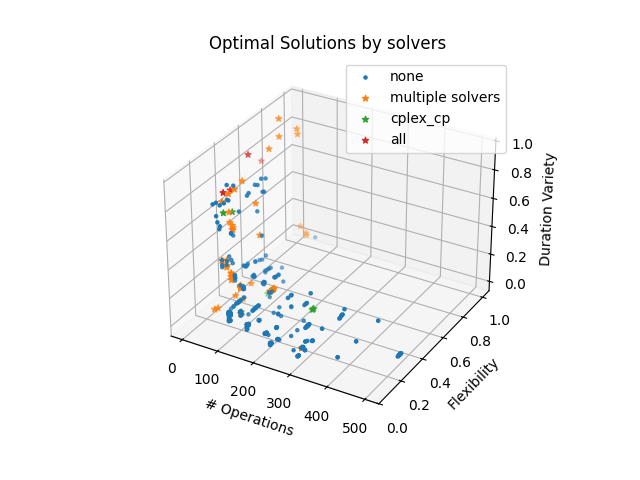

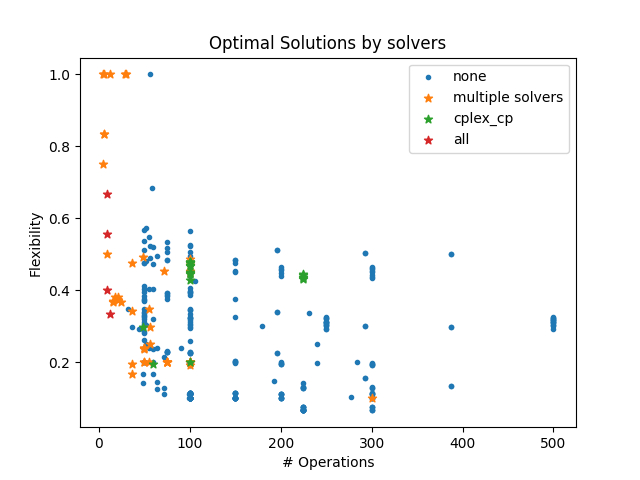

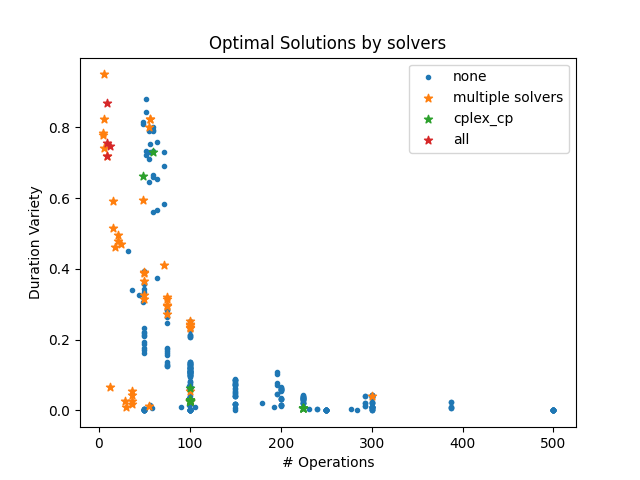

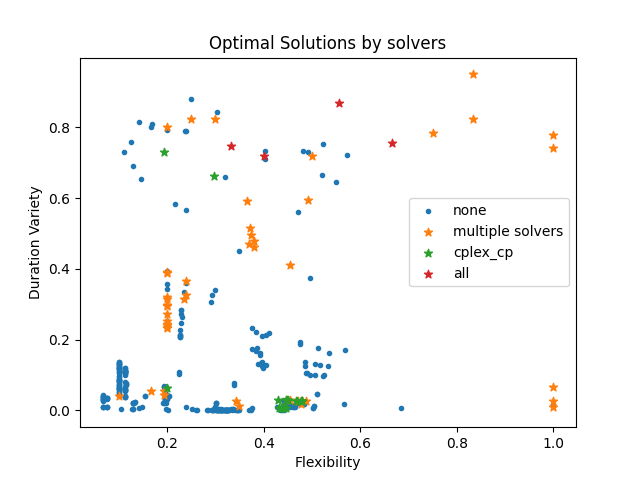

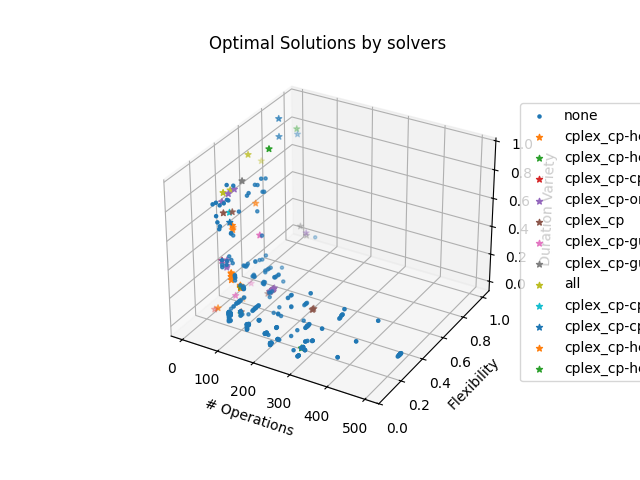

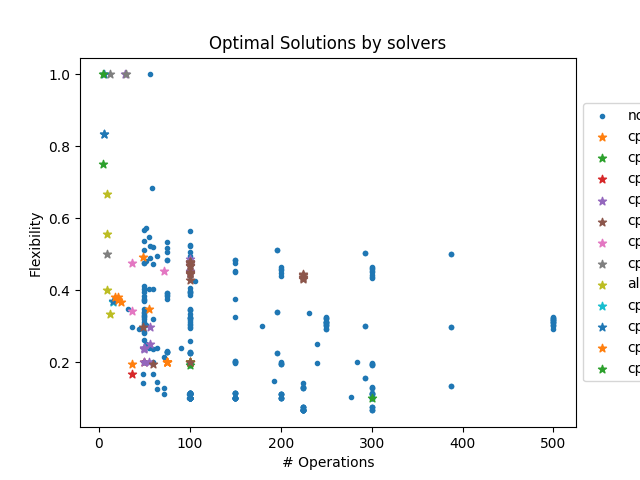

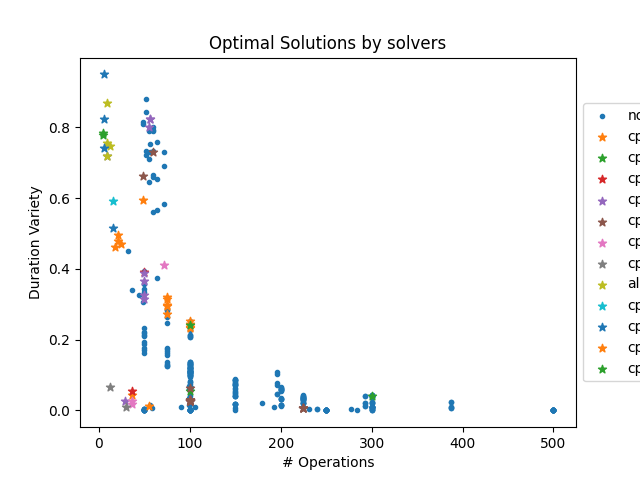

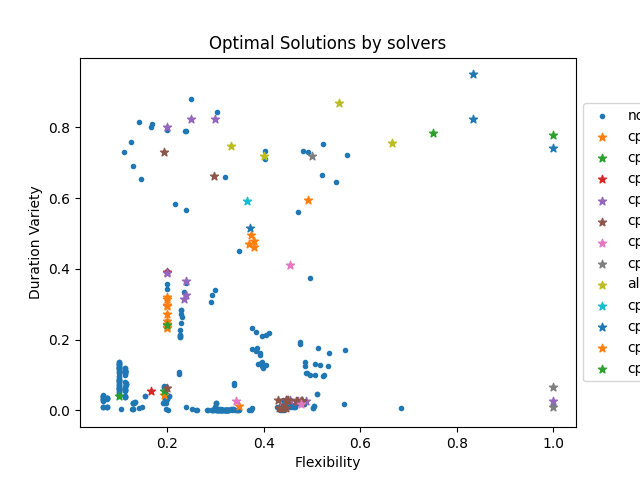

In [25]:
%matplotlib widget 
import matplotlib.pyplot as plt
def scatter_3d_grouped(f, o , dv, labels, markers, xlabel, ylabel, zlabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    one_solver = dict()
    for i in range(len(f)):
        if markers[i] == '*':
            if '-' in labels[i]:
                if 'multiple solvers' not in one_solver:
                    one_solver['multiple solvers'] = []
                one_solver['multiple solvers'].append([f[i], o[i], dv[i], markers[i]])
            else:
                if labels[i] not in one_solver:
                    one_solver[labels[i]] = []
                one_solver[labels[i]].append([f[i], o[i], dv[i], markers[i], 'r'])
        else:
            if 'none' not in one_solver:
                one_solver['none'] = []
            one_solver['none'].append([f[i], o[i], dv[i], '.', 'b'])
    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], [x[2] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][3])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    ax.legend()
    plt.show()

def scatter_2d_grouped(x, y, labels, markers, xlabel, ylabel, title):
    fig = plt.figure()
    ax = fig.add_subplot()
    one_solver = dict()
    for i in range(len(x)):
        if markers[i] == '*':
            if '-' in labels[i]:
                if 'multiple solvers' not in one_solver:
                    one_solver['multiple solvers'] = []
                one_solver['multiple solvers'].append([x[i], y[i], markers[i]])
            else:
                if labels[i] not in one_solver:
                    one_solver[labels[i]] = []
                one_solver[labels[i]].append([x[i], y[i], markers[i], 'r'])
        else:
            if 'none' not in one_solver:
                one_solver['none'] = []
            one_solver['none'].append([x[i], y[i], '.', 'b'])
    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][2])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    plt.show()

def scatter_3d(f, o , dv, labels, markers, xlabel, ylabel, zlabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    one_solver = dict()
    for i in range(len(f)):
        if labels[i] not in one_solver:
            one_solver[labels[i]] = []
        one_solver[labels[i]].append([f[i], o[i], dv[i], markers[i], 'r'])
    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], [x[2] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][3])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def scatter_2d(x, y, labels, markers, xlabel, ylabel, title):
    fig = plt.figure()
    ax = fig.add_subplot()
    one_solver = dict()
    for i in range(len(x)):
        if labels[i] not in one_solver:
            one_solver[labels[i]] = []
        one_solver[labels[i]].append([x[i], y[i], markers[i], 'r'])
    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][2])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

plot_data = []
labels = []
markers = []
colors =  []
for benchmark in benchmark_data:
    marker = '.'
    label = 'none'
    n_solvers = len(optimal_solvers[benchmark])
    if 'ga_average' in best_solvers[benchmark]:
        n_solvers -= 1
    all_solved = n_solvers == len(solvers)
    plot_data.append([benchmark_data[benchmark]['n_operations'], benchmark_data[benchmark]['flexibility'], benchmark_data[benchmark]['duration_variety']])
    if benchmark in optimal_solvers and len(optimal_solvers[benchmark]) > 0:
        marker = '*'# if len(optimal_solvers[benchmark]) == 1 else 'x'
        color = 'r' if len(optimal_solvers[benchmark]) == 1 else 'g'
        label = 'all' if all_solved else '-'.join(optimal_solvers[benchmark])#optimal_solvers[benchmark][0] if len(optimal_solvers[benchmark]) == 1 else 'multiple solvers' if benchmark in instances_with_some_best else 'all'
    markers.append(marker)
    labels.append(label)
ops = [x[0] for x in plot_data]
flex = [x[1] for x in plot_data]
dvs = [x[2] for x in plot_data]
scatter_3d_grouped(ops, flex, dvs, labels, markers, '# Operations', 'Flexibility', 'Duration Variety', 'Optimal Solutions by solvers')
scatter_2d_grouped(ops, flex, labels, markers, '# Operations', 'Flexibility', 'Optimal Solutions by solvers')
scatter_2d_grouped(ops, dvs, labels, markers, '# Operations', 'Duration Variety', 'Optimal Solutions by solvers')
scatter_2d_grouped(flex, dvs, labels, markers, 'Flexibility', 'Duration Variety', 'Optimal Solutions by solvers')

scatter_3d(ops, flex, dvs, labels, markers, '# Operations', 'Flexibility', 'Duration Variety', 'Optimal Solutions by solvers')
scatter_2d(ops, flex, labels, markers, '# Operations', 'Flexibility', 'Optimal Solutions by solvers')
scatter_2d(ops, dvs, labels, markers, '# Operations', 'Duration Variety', 'Optimal Solutions by solvers')
scatter_2d(flex, dvs, labels, markers, 'Flexibility', 'Duration Variety', 'Optimal Solutions by solvers')

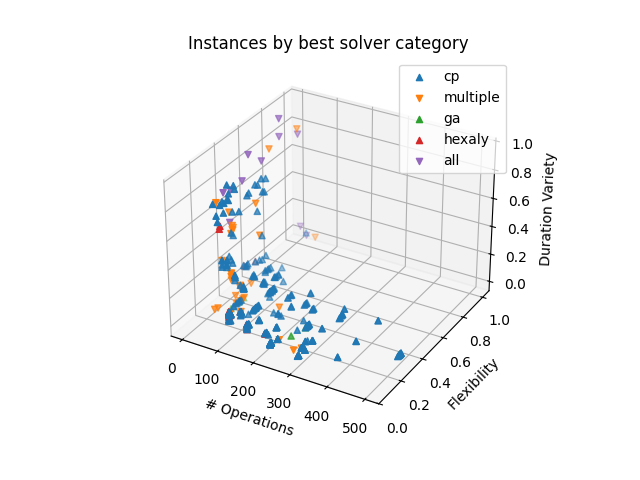

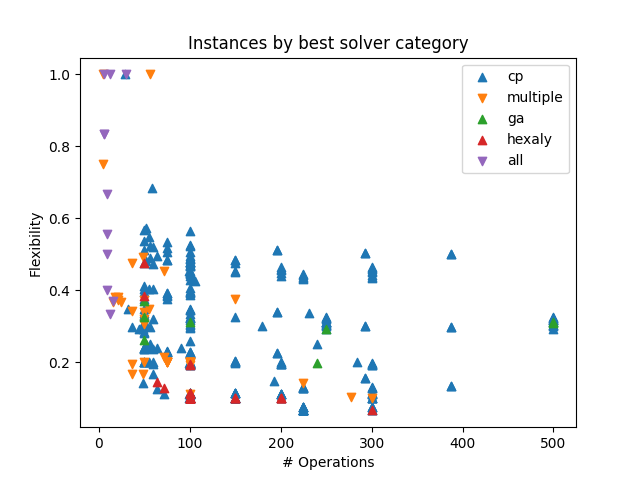

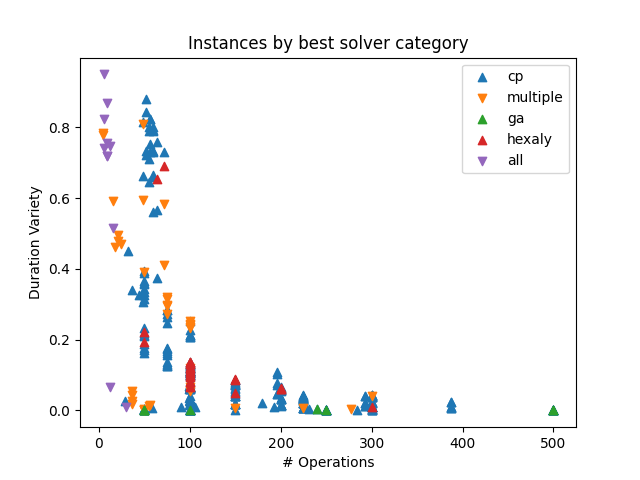

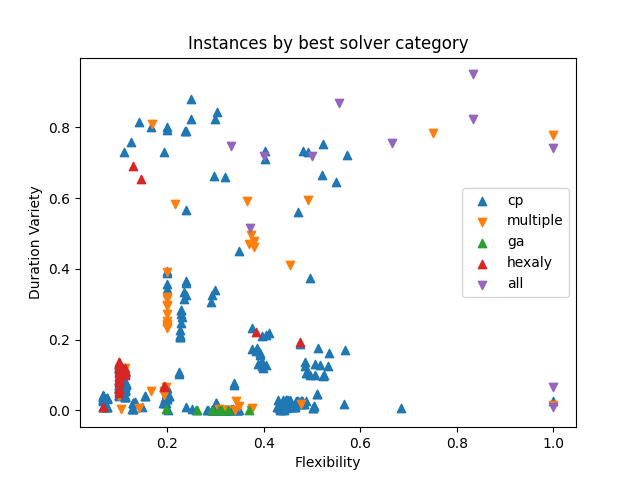

{'cp': 315, 'multiple': 39, 'ga': 8, 'hexaly': 29, 'all': 11}


In [26]:
%matplotlib widget 
import matplotlib.pyplot as plt

def scatter_3d(f, o , dv, labels, markers, xlabel, ylabel, zlabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    one_solver = dict()
    for i in range(len(f)):
        if labels[i] not in one_solver:
            one_solver[labels[i]] = []
        one_solver[labels[i]].append([f[i], o[i], dv[i], markers[i]])

    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], [x[2] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][3])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    if GROUPED:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend()
    plt.show()

def scatter_2d(x, y, labels, markers, xlabel, ylabel, title):
    fig = plt.figure()
    ax = fig.add_subplot()
    one_solver = dict()
    for i in range(len(x)):
        if labels[i] not in one_solver:
            one_solver[labels[i]] = []
        one_solver[labels[i]].append([x[i], y[i], markers[i]])
        
    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][2])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if GROUPED:
        ax.legend()
    else:
        ax.legend()
    plt.show()

def is_milp(instance):
    return (len(best_solvers[instance]) == 2 and 'gurobi' in best_solvers[instance] and 'cplex_lp' in best_solvers[instance]) or (len(best_solvers) == 1 and 'gurobi' in best_solvers) or (len(best_solvers) == 1 and 'cplex_lp' in best_solvers)

def is_cp(instance):
    return len(best_solvers[instance]) == 2 and 'cplex_cp' in best_solvers[instance] and 'ortools' in best_solvers[instance] or (len(best_solvers) == 1 and 'cplex_cp' in best_solvers) or (len(best_solvers) == 1 and 'ortools' in best_solvers)

def is_ga(instance):
    return len(best_solvers[instance]) == 1 and 'ga_best' in best_solvers[instance] or (len(best_solvers[instance]) == 2 and 'ga_average' in best_solvers[instance] and 'ga_best' in best_solvers[instance])

def is_hexaly(instance):
    return len(best_solvers[instance]) == 1 and 'hexaly' in best_solvers[instance]

def get_group(instance):
    groups = []
    """if is_milp(instance):
        groups.append('milp')
    if is_cp(instance):
        groups.append('cp')
    if is_hexaly(instance):
        groups.append('hexaly')
    if is_ga(instance):
        groups.append('ga')
    if len(groups) == 0:
        groups.append('multiple')
    elif len(groups) == 4:
        return 'all'"""
    if 'gurobi' in best_solvers[instance] or 'cplex_lp' in best_solvers[instance]:
        groups.append('milp')
    if 'ortools' in best_solvers[instance] or 'cplex_cp' in best_solvers[instance]:
        groups.append('cp')
    if 'hexaly' in best_solvers[instance]:
        groups.append('hexaly')
    if 'ga_best' in best_solvers[instance] or 'ga_average' in best_solvers[instance]:
        groups.append('ga')
    if len(groups) == 4:
        return 'all'
    if len(groups) > 1:
        return 'multiple'
    return groups[0]

def get_multi_groups(instance):
    groups = []
    if 'gurobi' in best_solvers[instance] or 'cplex_lp' in best_solvers[instance]:
        groups.append('milp')
    if 'ortools' in best_solvers[instance] or 'cplex_cp' in best_solvers[instance]:
        groups.append('cp')
    if 'hexaly' in best_solvers[instance]:
        groups.append('hexaly')
    if 'ga_best' in best_solvers[instance] or 'ga_average' in best_solvers[instance]:
        groups.append('ga')
    return groups

GROUPED = False
plot_data = []
labels = []
markers = []
marker_names = {'.': 'all', '^': 'one best', 'v': 'multiple best'}
counts = dict()
for benchmark in benchmark_data:
    plot_data.append([benchmark_data[benchmark]['n_operations'], benchmark_data[benchmark]['flexibility'], benchmark_data[benchmark]['duration_variety']])
    n_solvers = len(best_solvers[benchmark])
    if 'ga_average' in best_solvers[benchmark]:
        n_solvers -= 1
    all_solved = n_solvers >= len(solvers)
    marker = '.' if all_solved else '^' if n_solvers == 1 else 'v'
    if GROUPED:
        groups = get_multi_groups(benchmark)
        label = '-'.join(groups) if len(groups) < 4 else 'all'
    else:
        label = get_group(benchmark) # for simple grouped
    if label not in counts:
        counts[label] = 0    
    counts[label] += 1
    markers.append(marker)
    labels.append(label)

scatter_3d([x[0] for x in plot_data], [x[1] for x in plot_data], [x[2] for x in plot_data], labels, markers, '# Operations', 'Flexibility', 'Duration Variety', 'Instances by best solver category')
scatter_2d([x[0] for x in plot_data], [x[1] for x in plot_data], labels, markers, '# Operations', 'Flexibility', 'Instances by best solver category')
scatter_2d([x[0] for x in plot_data], [x[2] for x in plot_data], labels, markers, '# Operations', 'Duration Variety', 'Instances by best solver category')
scatter_2d([x[1] for x in plot_data], [x[2] for x in plot_data], labels, markers, 'Flexibility', 'Duration Variety', 'Instances by best solver category')
print(counts)

In [27]:
counts = dict()
for instance in best_solvers:
    best = best_solvers[instance]
    if 'ga_average' in best:
        best.remove('ga_average')
    name = '-'.join(best)
    if name not in counts:
        counts[name] = 0
    counts[name] += 1
print(counts)

{'cplex_cp': 283, 'cplex_cp-ortools': 17, 'cplex_cp-ga_best': 6, 'ga_best': 8, 'cplex_cp-hexaly': 5, 'cplex_cp-hexaly-ortools': 16, 'ga_best-ortools': 1, 'hexaly': 29, 'cplex_cp-cplex_lp-hexaly-ortools': 2, 'ortools': 15, 'cplex_cp-gurobi-hexaly-ortools': 3, 'cplex_cp-ga_best-gurobi-hexaly-ortools': 3, 'cplex_cp-cplex_lp-ga_best-gurobi-hexaly-ortools': 4, 'cplex_cp-cplex_lp-ga_best-gurobi-ortools': 1, 'cplex_cp-cplex_lp-ga_best-hexaly-ortools': 4, 'cplex_cp-ga_best-hexaly-ortools': 5}
